In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
metric = "rmse"
error = {
    name: xr.open_dataset(
        f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/{key}-forecasts-vs-hrrr-analysis/{metric}.lam.nc",
        decode_timedelta=True,
    )
    for name, key in zip(["HRRR", "GFS"], ["hrrr", "gfs"])
}
error["Nested-EAGLE 1\u00b0/15km"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/logoffline-trim10-ll10-win4320/inference-validation/{metric}.nested-lam.nc", decode_timedelta=True)

In [4]:
error = {k: error[k] for k in ["Nested-EAGLE 1\u00b0/15km", "HRRR", "GFS"]}

In [5]:
nice_names = {
    "sp": "Surface Pressure",
    "u10": "10m Zonal Wind",
    "v10": "10m Meridional Wind",
    "t2m": "2m Temperature",
    "sh2": "2m Specific Humidity",
    "gh": "Geopotential Height",
    "u": "Zonal Wind",
    "v": "Meridional Wind",
    "w": "Vertical Velocity",
    "t": "Temperature",
    "q": "Specific Humidity",
}

In [6]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    for label, xds in error.items():
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        df = plotme.to_dataframe().reset_index()
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            **kwargs,
        )
    xticks = plotme.fhr.values
    xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel="Forecast Hour" if ax.get_subplotspec().is_last_row() else "",
        title=nice_names[varname] if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
    )
    if ax.get_subplotspec().is_last_col():
        ax.annotate(
            "",
            xy=(1.05, 0.75),  # Arrowhead position (bottom-right of plot area)
            xytext=(1.05, 0.25), # Text position (above the arrowhead)
            xycoords='axes fraction', # Use axes coordinates for positioning
            textcoords='axes fraction', # Use axes coordinates for positioning
            arrowprops=dict(
                arrowstyle="<-",
                connectionstyle="arc3",
                color="black",
                lw=8,
            ),
            ha='center', # Horizontal alignment of the text
            va='center', # Vertical alignment of the text
            rotation=90 # Rotate the text by 90 degrees
        )
        ax.text(
            1.15,
            .5,
            "Lower is Better",
            rotation=90,
            ha="center",
            va="center",
            transform=ax.transAxes,
        )
    #ax.legend(frameon=False, loc="lower right")

/tmp/ipykernel_79236/222266667.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=.1, rect=[0, 0.1, 1, 1])


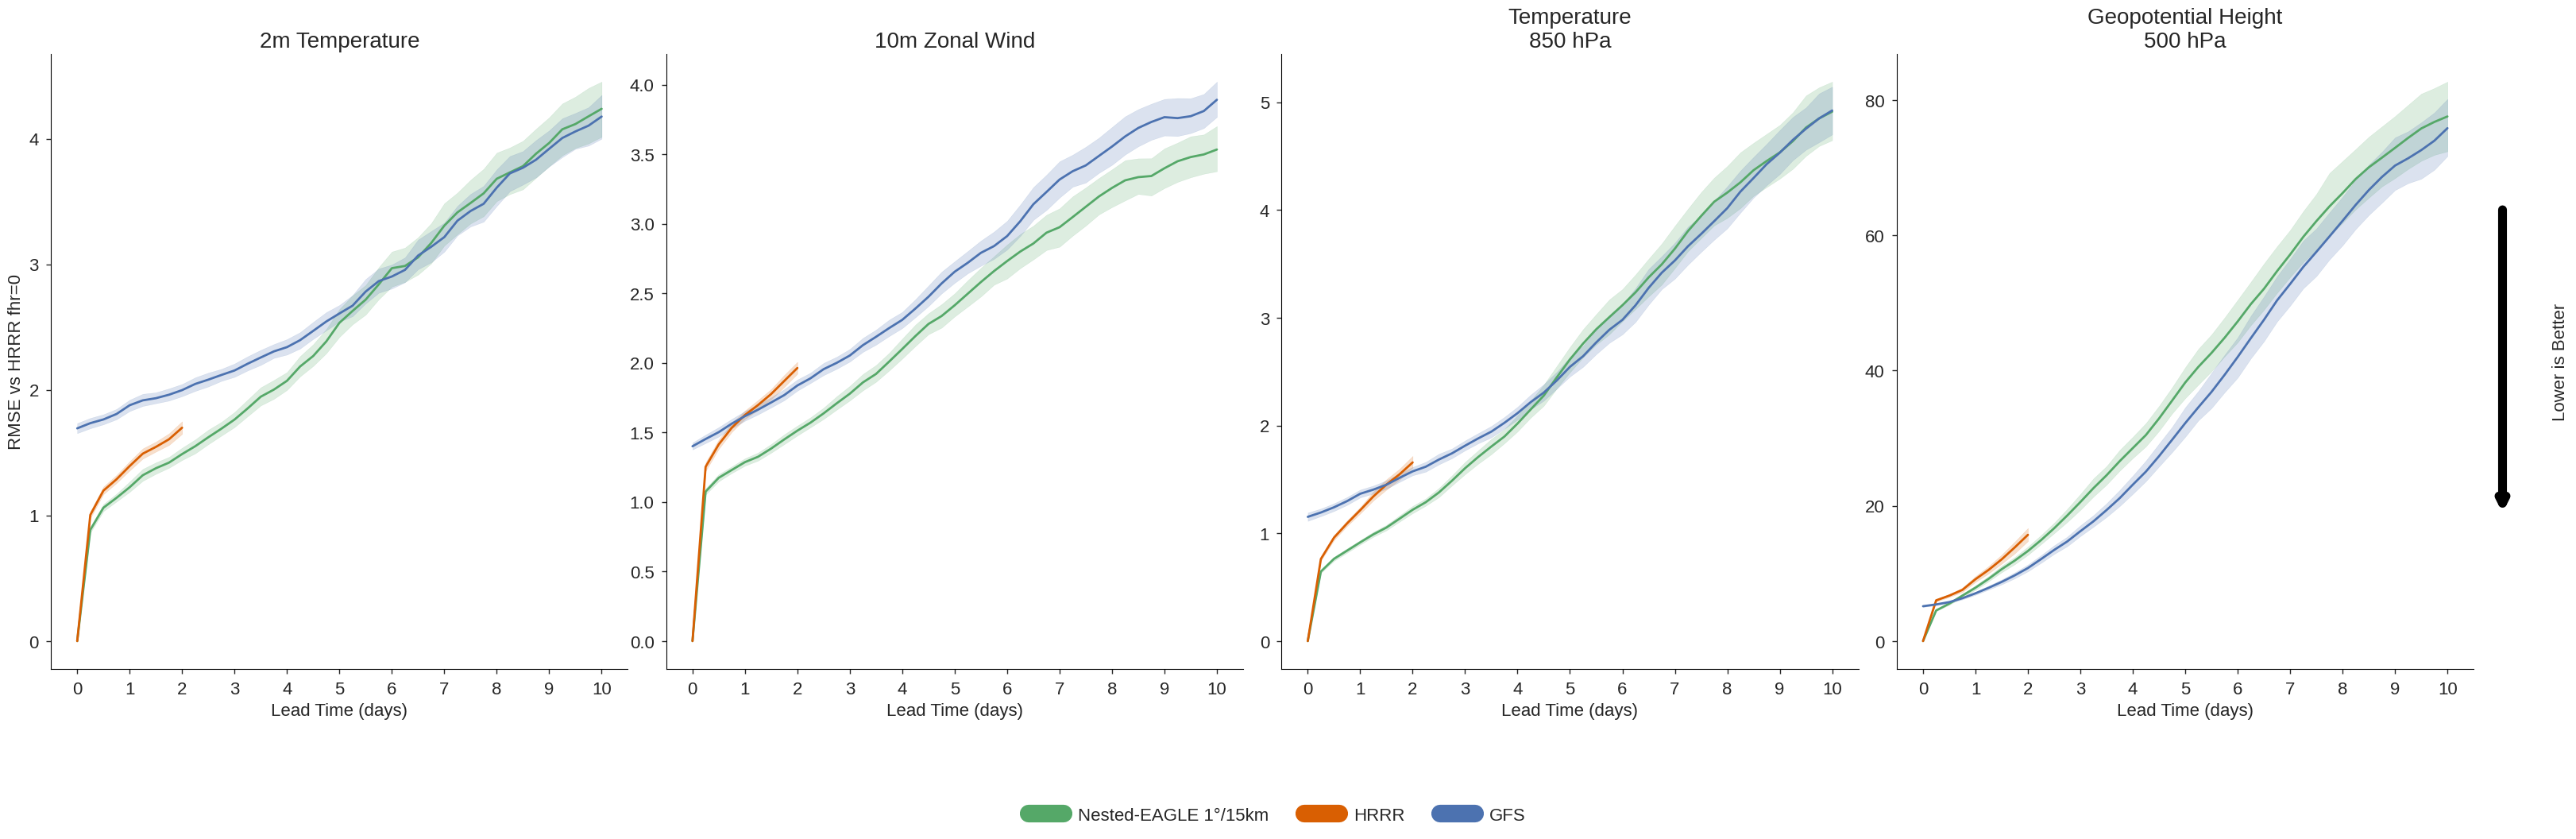

In [7]:
ncols = 4
fig, axs = plt.subplots(1, ncols, figsize=(8*ncols, 10), constrained_layout=True)

handles = []
labels = []
for varname, level, ax in zip(
    ["t2m", "u10", "t", "gh"], 
    [None, None, 850, 500],
    axs,
):
    sel = {} if level is None else {"level": level}
    single_plot(ax=ax, dsdict=error, varname=varname, sel=sel)
    if len(handles) == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax.get_legend().remove()
    ax.set(
        xticks=np.arange(0, 241, 24),
        xticklabels=np.arange(11),
        ylabel="RMSE vs HRRR fhr=0" if ax.get_subplotspec().is_first_col() else "",
        xlabel="Lead Time (days)",
    )
    if level is not None:
        ax.set(title=nice_names[varname] + f"\n{level} hPa")

legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncols=len(labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(16)
plt.tight_layout(pad=.1, rect=[0, 0.1, 1, 1])
#fig.savefig("figures/poster_rmse_10d.pdf", bbox_inches="tight")

/tmp/ipykernel_79236/3494296672.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=.1, rect=[0, 0.1, 1, 1])


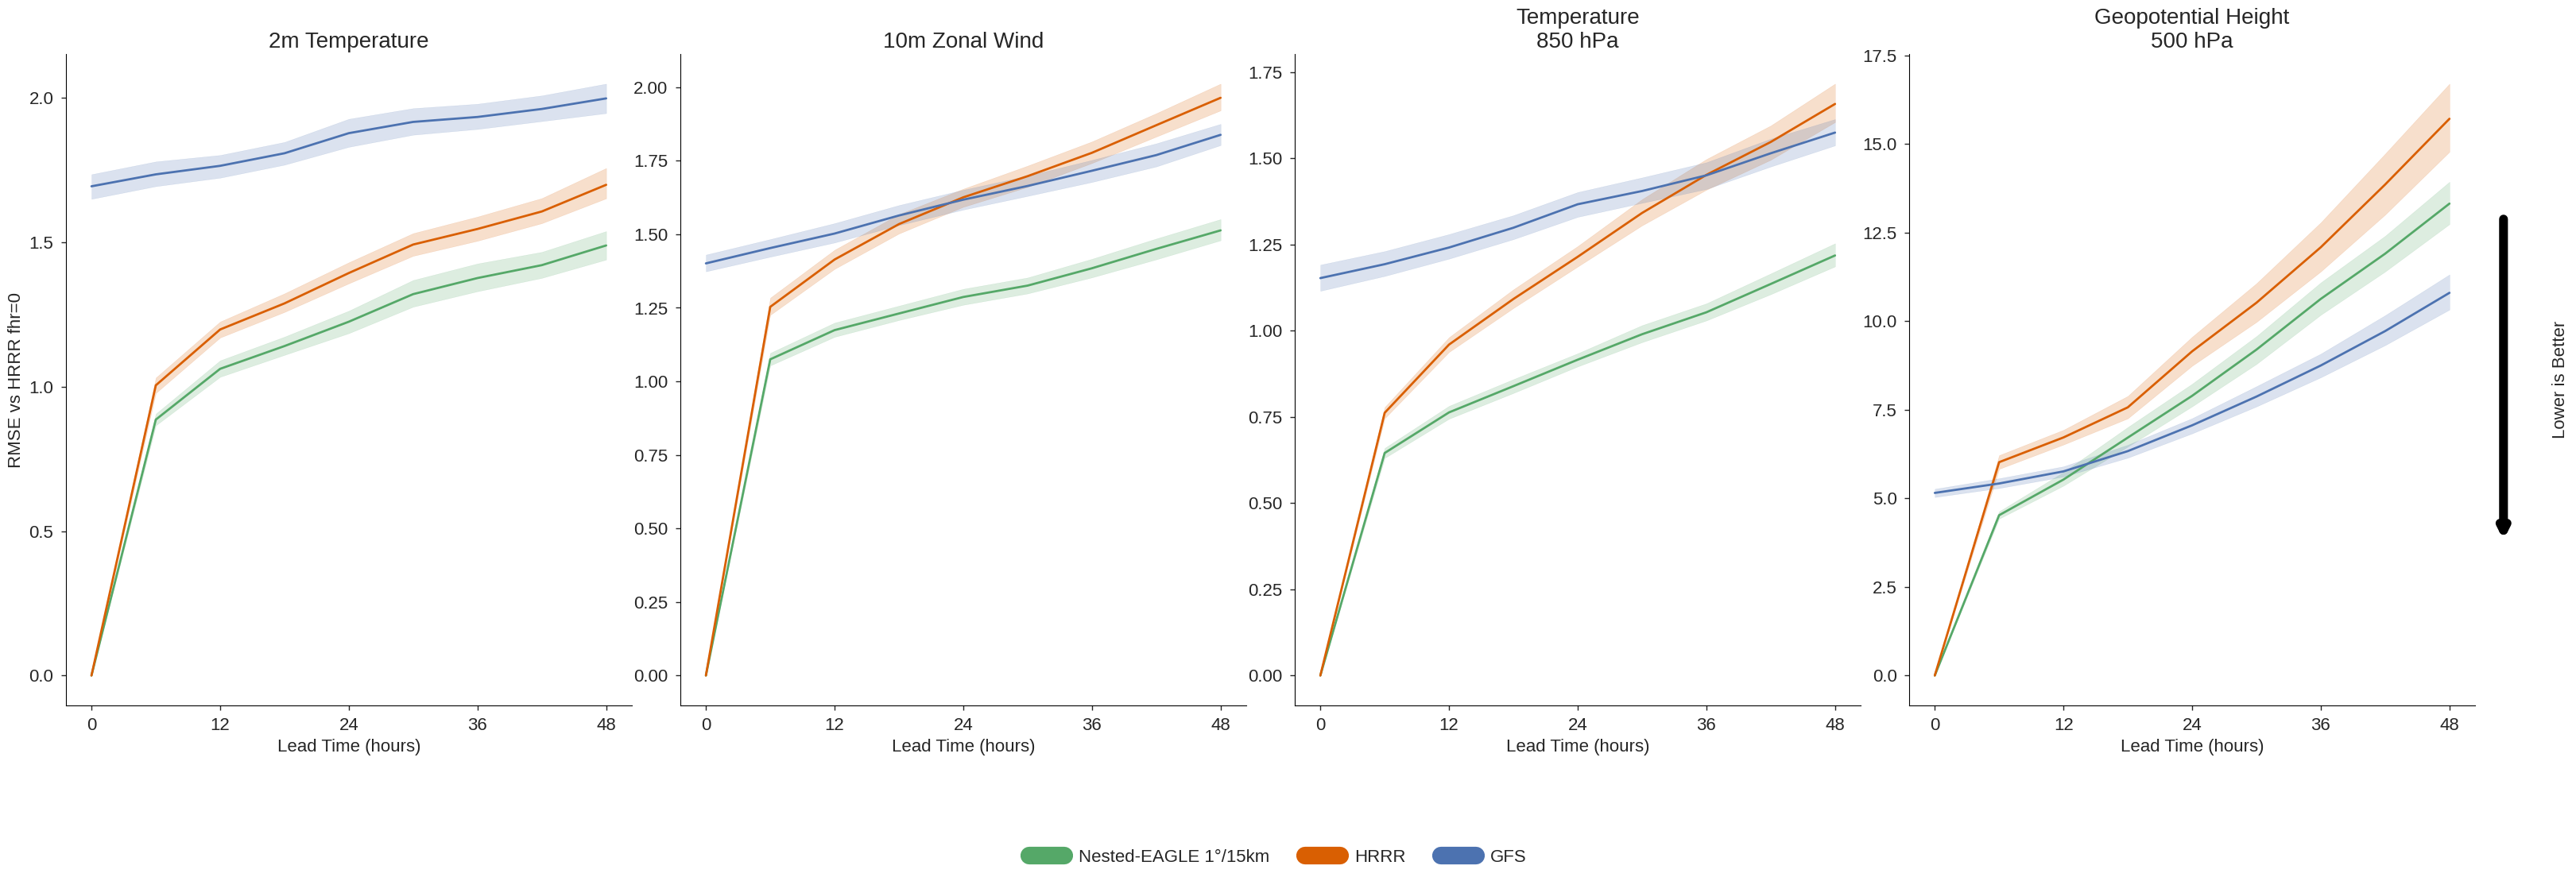

In [8]:
ncols = 4
fig, axs = plt.subplots(1, ncols, figsize=(8*ncols, 10.5), constrained_layout=True)

handles = []
labels = []
for varname, level, ax in zip(
    ["t2m", "u10", "t", "gh"], 
    [None, None, 850, 500],
    axs,
):
    sel = {} if level is None else {"level": level}
    sel["fhr"] = slice(49)
    single_plot(ax=ax, dsdict=error, varname=varname, sel=sel)
    if len(handles) == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax.get_legend().remove()
    ax.set(
        xticks=np.arange(0, 49, 12),
        xlabel="Lead Time (hours)",
        ylabel="RMSE vs HRRR fhr=0" if ax.get_subplotspec().is_first_col() else "",
    )
    if level is not None:
        ax.set(title=nice_names[varname] + f"\n{level} hPa")

legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncols=len(labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(16)
plt.tight_layout(pad=.1, rect=[0, 0.1, 1, 1])
#fig.savefig("figures/poster_rmse_48h.pdf", bbox_inches="tight")

### Precipitation evaluation

In [9]:
import pandas as pd
import io

In [10]:
csv_monthly_means = """FHR006,,,,
Month,AORC,GFS,HRRR,Nested-EAGLE 1\u00b0/15km
Feb 2023,0.423,0.483,0.400,0.380
Mar 2023,0.559,0.637,0.508,0.476
Apr 2023,0.482,0.573,0.431,0.416
May 2023,0.529,0.574,0.361,0.375
June 2023,0.631,0.618,0.411,0.416
Jul 2023,0.585,0.499,0.388,0.399
Aug 2023,0.606,0.507,0.404,0.412
Sep 2023,0.441,0.383,0.291,0.308
Oct 2023,0.457,0.432,0.370,0.378
Nov 2023,0.320,0.327,0.271,0.266
Dec 2023,0.448,0.441,0.399,0.404
Jan 2024,0.616,0.656,0.565,0.562
FHR024,,,,
Month,AORC,GFS,HRRR,Nested-EAGLE 1\u00b0/15km
Feb 2023,0.423,0.491,0.512,0.368
Mar 2023,0.559,0.645,0.656,0.453
Apr 2023,0.482,0.599,0.569,0.391
May 2023,0.529,0.600,0.506,0.309
June 2023,0.631,0.630,0.577,0.363
Jul 2023,0.585,0.530,0.560,0.323
Aug 2023,0.606,0.521,0.566,0.367
Sep 2023,0.441,0.388,0.424,0.263
Oct 2023,0.457,0.433,0.487,0.352
Nov 2023,0.320,0.332,0.361,0.247
Dec 2023,0.448,0.448,0.497,0.395
Jan 2024,0.602,0.641,0.686,0.546"""

In [11]:
def csv2ds(csvdata):
    
    csv_file = io.StringIO(csvdata)
    
    # Read the first table (FHR006) into a pandas DataFrame.
    # We skip the header row and read 12 rows of data.
    df_fhr6 = pd.read_csv(csv_file, skiprows=1, nrows=12)
    df_fhr6.rename(columns={'Month': 'time'}, inplace=True)
    df_fhr6['fhr'] = 6
    
    # Reset the file pointer to the beginning to read the second table.
    csv_file.seek(0)
    
    # Read the second table (FHR024). We skip to the correct row.
    df_fhr24 = pd.read_csv(csv_file, skiprows=15, nrows=12)
    df_fhr24.rename(columns={'Month': 'time'}, inplace=True)
    df_fhr24['fhr'] = 24
    
    # Concatenate the two DataFrames into a single one.
    df_combined = pd.concat([df_fhr6, df_fhr24])
    
    # Convert the 'time' column to a proper datetime format.
    df_combined['time'] = pd.to_datetime(df_combined['time'])
    
    # Set the 'time' and 'fhr' columns as the index. This is a crucial
    # step to define the dimensions for the xarray dataset.
    df_combined = df_combined.set_index(['time', 'fhr'])
    return xr.Dataset.from_dataframe(df_combined)

In [12]:
mds = csv2ds(csv_monthly_means)

/tmp/ipykernel_79236/3755250762.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_combined['time'] = pd.to_datetime(df_combined['time'])


In [13]:
import matplotlib.dates as mdates

/tmp/ipykernel_79236/3295136358.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.1, 1, 1])


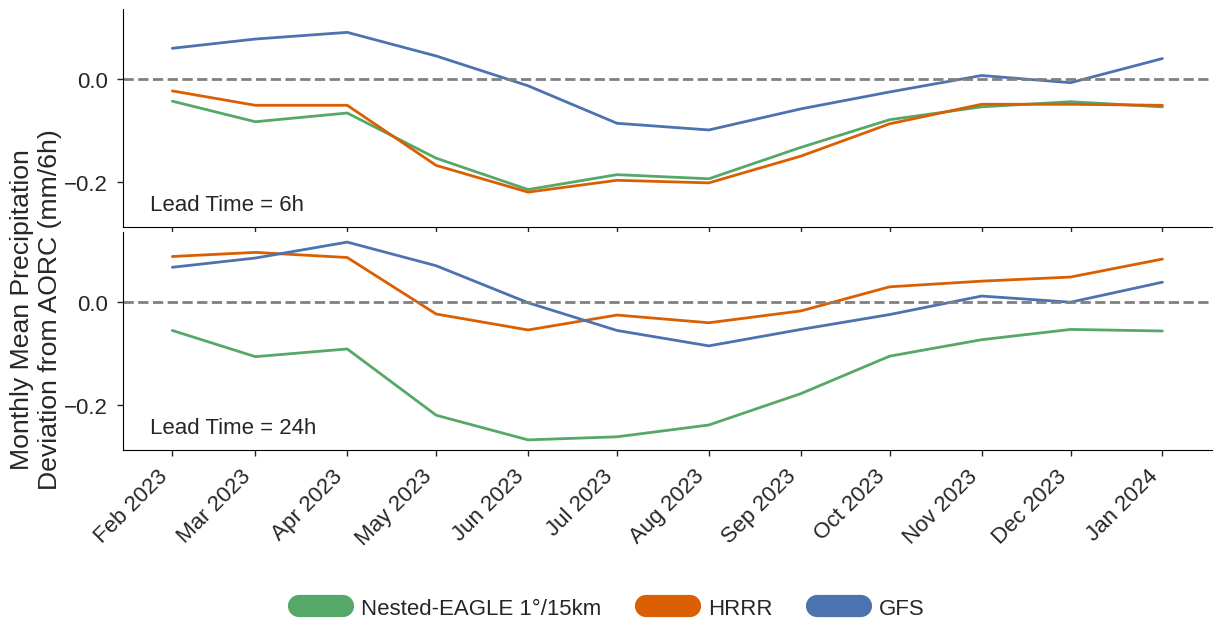

In [22]:
nrows = 2
fig, axs = plt.subplots(nrows, 1, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)

handles = []
labels = []

for fhr, ax in zip(mds.fhr.values, axs):
#    for label in ["Nested-EAGLE 1\u00b0/15km", "HRRR", "GFS", "AORC"]:
    for label in ["Nested-EAGLE 1\u00b0/15km", "HRRR", "GFS"]:
    
        kw = {"color": "black"} if label == "AORC" else {}
        plotme = mds[label].sel(fhr=fhr)
        plotme = plotme - mds["AORC"].sel(fhr=fhr)
        plotme.plot(ax=ax, label=label, **kw)
    ax.set(
        xlabel="",
        xticks=plotme.time.values,
        title="",
#        ylabel="Monthly Mean Precip Deviation from AORC (mm)",
    )
    fig.supylabel("Monthly Mean Precipitation\nDeviation from AORC (mm/6h)", ha="center")
    ax.text(.025, .1, f"Lead Time = {fhr}h", transform=ax.transAxes, ha="left", va="center")
    ax.xaxis.set_major_formatter(
        mdates.DateFormatter("%b %Y"),
    )
    ax.axhline(y=0, color="gray", linestyle="--")
    plt.xticks(rotation=45, ha="right")
    if len(handles) == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    

#legend = fig.legend(
#    handles,
#    [x.replace(" ", "\n") for x in labels],
#    loc='center left',
#    bbox_to_anchor=(1., .6),
#    ncols=1,#len(labels),
#    frameon=False,
#)
#
#for line in legend.get_lines():
#    line.set_linewidth(16)
    
legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncols=len(labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(16)
plt.tight_layout(pad=0, rect=[0, 0.1, 1, 1])
fig.savefig("figures/monthly_mean_precip.jpeg", bbox_inches="tight", dpi=300)

In [16]:
csv_fss="""FHR006,,,
Amount (mm),GFS,HRRR,Nested-EAGLE 1\u00b0/15km
1,0.703,0.708,0.722
2,0.668,0.679,0.684
5,0.574,0.610,0.588
10,0.431,0.512,0.451
20,0.245,0.362,0.266
25,0.184,0.303,0.201
30,0.139,0.254,0.150
40,0.079,0.179,0.083
50,0.047,0.123,0.046
60,0.032,0.092,0.031
70,0.029,0.074,0.023
75,0.026,0.059,0.022
80,0.021,0.057,0.018
90,0.023,0.053,0.014
100,0.022,0.047,0.007
FHR24,,,
Amount (mm),GFS,HRRR,Nested-EAGLE 1\u00b0/15km
1,0.656,0.650,0.635
2,0.607,0.606,0.577
5,0.489,0.513,0.458
10,0.342,0.404,0.315
20,0.181,0.254,0.152
25,0.134,0.201,0.102
30,0.103,0.161,0.071
40,0.053,0.105,0.035
50,0.028,0.066,0.010
60,0.016,0.044,0.002
70,0.010,0.032,0.001
75,0.012,0.028,0.002
80,0.011,0.025,0.003
90,0.007,0.020,0.001
100,0.011,0.022,0.000"""

In [17]:
def csv2fds(csvdata):

    csv_file = io.StringIO(csvdata)

    # Read the first table (FHR006) into a pandas DataFrame.
    # We skip the header row and read 15 rows of data.
    df_fhr6 = pd.read_csv(csv_file, skiprows=1, nrows=15)
    df_fhr6.rename(columns={'Amount (mm)': 'amount'}, inplace=True)
    df_fhr6['fhr'] = 6
    
    # Reset the file pointer to the beginning to read the second table.
    csv_file.seek(0)
    
    # Read the second table (FHR24). We skip to the correct row.
    df_fhr24 = pd.read_csv(csv_file, skiprows=18, nrows=15)
    df_fhr24.rename(columns={'Amount (mm)': 'amount'}, inplace=True)
    df_fhr24['fhr'] = 24
    
    # Concatenate the two DataFrames into a single one.
    df_combined = pd.concat([df_fhr6, df_fhr24])
    
    # Set the 'amount' and 'fhr' columns as the index. This is a crucial
    # step to define the dimensions for the xarray dataset.
    df_combined = df_combined.set_index(['amount', 'fhr'])
    
    # Convert the pandas DataFrame to an xarray Dataset.
    return xr.Dataset.from_dataframe(df_combined)


In [18]:
fds = csv2fds(csv_fss)

/tmp/ipykernel_79236/4163515725.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=.15, rect=[0, 0.1, 1, 1])


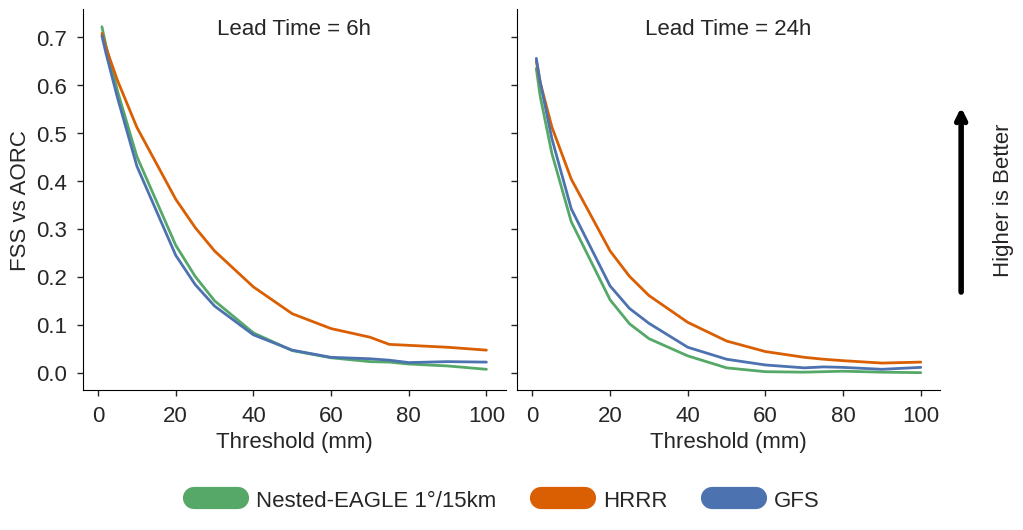

In [21]:
ncols = 2
fig, axs = plt.subplots(1, ncols, figsize=(10, 5), constrained_layout=True, sharex=True, sharey=True)

handles = []
labels = []
for fhr, ax in zip(fds.fhr.values, axs):
    lastcol = ax.get_subplotspec().is_last_col()
    for label in ["Nested-EAGLE 1\u00b0/15km", "HRRR", "GFS"]:
    
        plotme = fds[label].sel(fhr=fhr)
        plotme.plot(ax=ax, label=label, **kw)
        
    ax.set(
        xlabel="Threshold (mm)",
        title="",
        xticks=np.arange(0, 101, 20),
        yticks=np.arange(8)/10,
        ylabel="FSS vs AORC" if ax.get_subplotspec().is_first_col() else "",
    )
    ax.text(.5, .95, f"Lead Time = {fhr}h", transform=ax.transAxes, ha="center", va="center")
    #ax.legend(title=f"Lead Time = {fhr}h", loc="upper right", frameon=False)
    #if fhr == fds.fhr.values[-1]:
    #    plt.legend(frameon=False)
    if len(handles) == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    if ax.get_subplotspec().is_last_col():
        ax.annotate(
            "",
            xy=(1.05, 0.25),  # Arrowhead position (bottom-right of plot area)
            xytext=(1.05, 0.75), # Text position (above the arrowhead)
            xycoords='axes fraction', # Use axes coordinates for positioning
            textcoords='axes fraction', # Use axes coordinates for positioning
            arrowprops=dict(
                arrowstyle="<-",
                connectionstyle="arc3",
                color="black",
                lw=4,
            ),
            ha='center', # Horizontal alignment of the text
            va='center', # Vertical alignment of the text
            rotation=90 # Rotate the text by 90 degrees
        )
        ax.text(
            1.15,
            .5,
            "Higher is Better",
            rotation=90,
            ha="center",
            va="center",
            transform=ax.transAxes,
        )
    
#legend = fig.legend(
#    handles,
#    [x.replace(" ", "\n") for x in labels],
#    loc='center left',
#    bbox_to_anchor=(.8, .6),
#    ncols=1,#len(labels),
#    frameon=False,
#)
#
#for line in legend.get_lines():
#    line.set_linewidth(16)
##plt.tight_layout(pad=0.05, rect=[0, 0.1, 1, 1])
legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncols=len(labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(16)
plt.tight_layout(pad=.15, rect=[0, 0.1, 1, 1])

fig.savefig("figures/fss_conus.jpeg", bbox_inches="tight", dpi=300)